# Introduction

This notebook investigates how odors are represented in the piriform cortex by analyzing population-level neural activity across different cortical layers and odor sets. We use the dataset from [Pashkovski et al. 2020](https://doi.org/10.1038/s41586-020-2451-1) "Structure and flexibility in cortical representations of odour space," and reproduce and extend several core analyses. Some components of the code, including dataset loading and initial preprocessing, are adapted from the original notebook. Our work builds on key figures from the paper–particularly the use of RDMs–to investigate how odor structure and cortical architecture shape population-level coding.

In [18]:
%config InlineBackend.figure_format = 'retina'

In [19]:
import sys
import math
from pathlib import Path

import h5py
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, scale

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform

from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

sns.set(style="ticks")

# load odor information

* Each odor is characterized by its chemical structure and grouped into one of three curated odor sets—global, clustered, or tiled—designed to probe distinct dimensions of odor space.

In [20]:
base_path = Path().resolve().parent
data_path = base_path / "data"

sys.path.append(str(base_path / "src"))

In [21]:
GROUPS = ["global", "clustered", "tiled"]
LAYERS = ["l2", "l3"]
df_odors = pd.read_csv(data_path / "odor_sets_with_cids.csv", index_col=[0, 1])
df_odors

odor
set    cid                      
global 13233      trithioacetone
       159055          R-camphor
       109332     isothiocineole
       62842            linalool
       12813   gamma-decalactone
...                          ...
tiled  264         butanoic acid
       7991       pentanoic acid
       8892        hexanoic acid
       8094       heptanoic acid
       379         octanoic acid

[66 rows x 1 columns]

In [22]:
odor_cids = {g: df_odors.loc[g].index.values for g in GROUPS}
all_cids = np.hstack([v for v in odor_cids.values()])
odor_cids

{'global': array([  13233,  159055,  109332,   62842,   12813,    8186,   17356,
        6008212,  228987,    7662,  106441,    8815,    1127,    1045,
         519793,    2346,    8405,     798,   11902,   26808,    6115,
           7976]),
 'clustered': array([6999957,    8697,   62089,   14475,    7662,  576240,    8792,
           8186,    8187, 5283356, 6436710,  159055,   14525,  444294,
          14514,   12097,   11902,   69201,  519793,    8118,   98781,
          11002]),
 'tiled': array([  527,   261,  8063,  8130,   454,   180,  6569,  7895, 11583,
         8051,  8093,  8857,  7997, 31272, 12348,  8908,  1032,   264,
         7991,  8892,  8094,   379])}

# load chemical descriptors

* For more information on the chemical descriptors, please refer to the Pashkovski paper, or the [intuitive_descriptors.csv](../data/intuitive_descriptors.csv) file in the data folder.

In [23]:
# index data by "Name" which refers to each molecules Pubchem CID.
df_chem = pd.read_hdf(
    data_path / "chemical_descriptors.h5", key="descriptors"
).set_index("NAME")
df_chem = df_chem.iloc[:, 1:]
df_chem.head()

,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,CATS3D_10_LL,CATS3D_11_LL,CATS3D_12_LL,CATS3D_13_LL,CATS3D_14_LL,CATS3D_15_LL,CATS3D_16_LL,CATS3D_17_LL,CATS3D_18_LL,CATS3D_19_LL
NAME,,,,,,,,,,,,,,,,,,,,,
4965,229.08,10.909,14.089,21.302,15.068,23.336,0.671,1.014,0.718,1.111,...,0,0,0,0,0,0,0,0,0,0
7478,152.16,8.008,12.252,19.516,12.409,21.289,0.645,1.027,0.653,1.120,...,0,0,0,0,0,0,0,0,0,0
61431,174.32,5.127,17.224,33.374,19.284,38.986,0.507,0.982,0.567,1.147,...,0,0,0,0,0,0,0,0,0,0
6435837,284.43,6.321,26.751,44.258,29.046,50.401,0.594,0.984,0.645,1.120,...,8,2,2,0,0,0,0,0,0,0
61434,290.49,5.696,28.332,49.909,31.330,57.647,0.556,0.979,0.614,1.130,...,8,8,3,6,5,5,6,2,4,0


In [24]:
# Filter out non-volatile molecules based on molecular weight
df_chem = df_chem.loc[df_chem.MW < 300]
df_chem = df_chem.loc[df_chem.MW > 50]

# remove descriptors that have a zero value across all the odors we've tested
colFilter = ~(df_chem.loc[all_cids].astype(bool).sum(0) == 0)
df_chem = df_chem.loc[:, colFilter]

# z-score each descriptor feature across the full odor library
chem_scaled = scale(df_chem.values, axis=0)

In [25]:
odor_idx = {}
for k, v in odor_cids.items():
    odor_idx[k] = [np.where(df_chem.index == vv)[0][0] for vv in v]

# load neural pseudopopulations

* responses are concatenated across mice

In [26]:
with h5py.File(data_path / "pseudopopulations.h5", "r") as hf:
    neural_dict = {k: v[()] for k, v in hf["pseudopopulations"].items()}
    
# trials x ROIs x odors
for k, v in neural_dict.items():
    print(k, v.shape)

Boutons (6, 3160, 22)
Model (1, 72914, 22)
TeLC L2 (4, 435, 22)
TeLC L3 (4, 590, 22)
clustered_l2 (10, 867, 22)
clustered_l3 (10, 488, 22)
global_l2 (10, 854, 22)
global_l3 (10, 616, 22)
tiled_l2 (7, 427, 22)
tiled_l3 (7, 334, 22)


# Clustering and Visualization of Population Responses

This section visualizes population-level neural responses, applies hierarchical clustering to uncover tuning structure, and includes sparseness and silhouette analyses to quantify the selectivity and organization of odor representations.

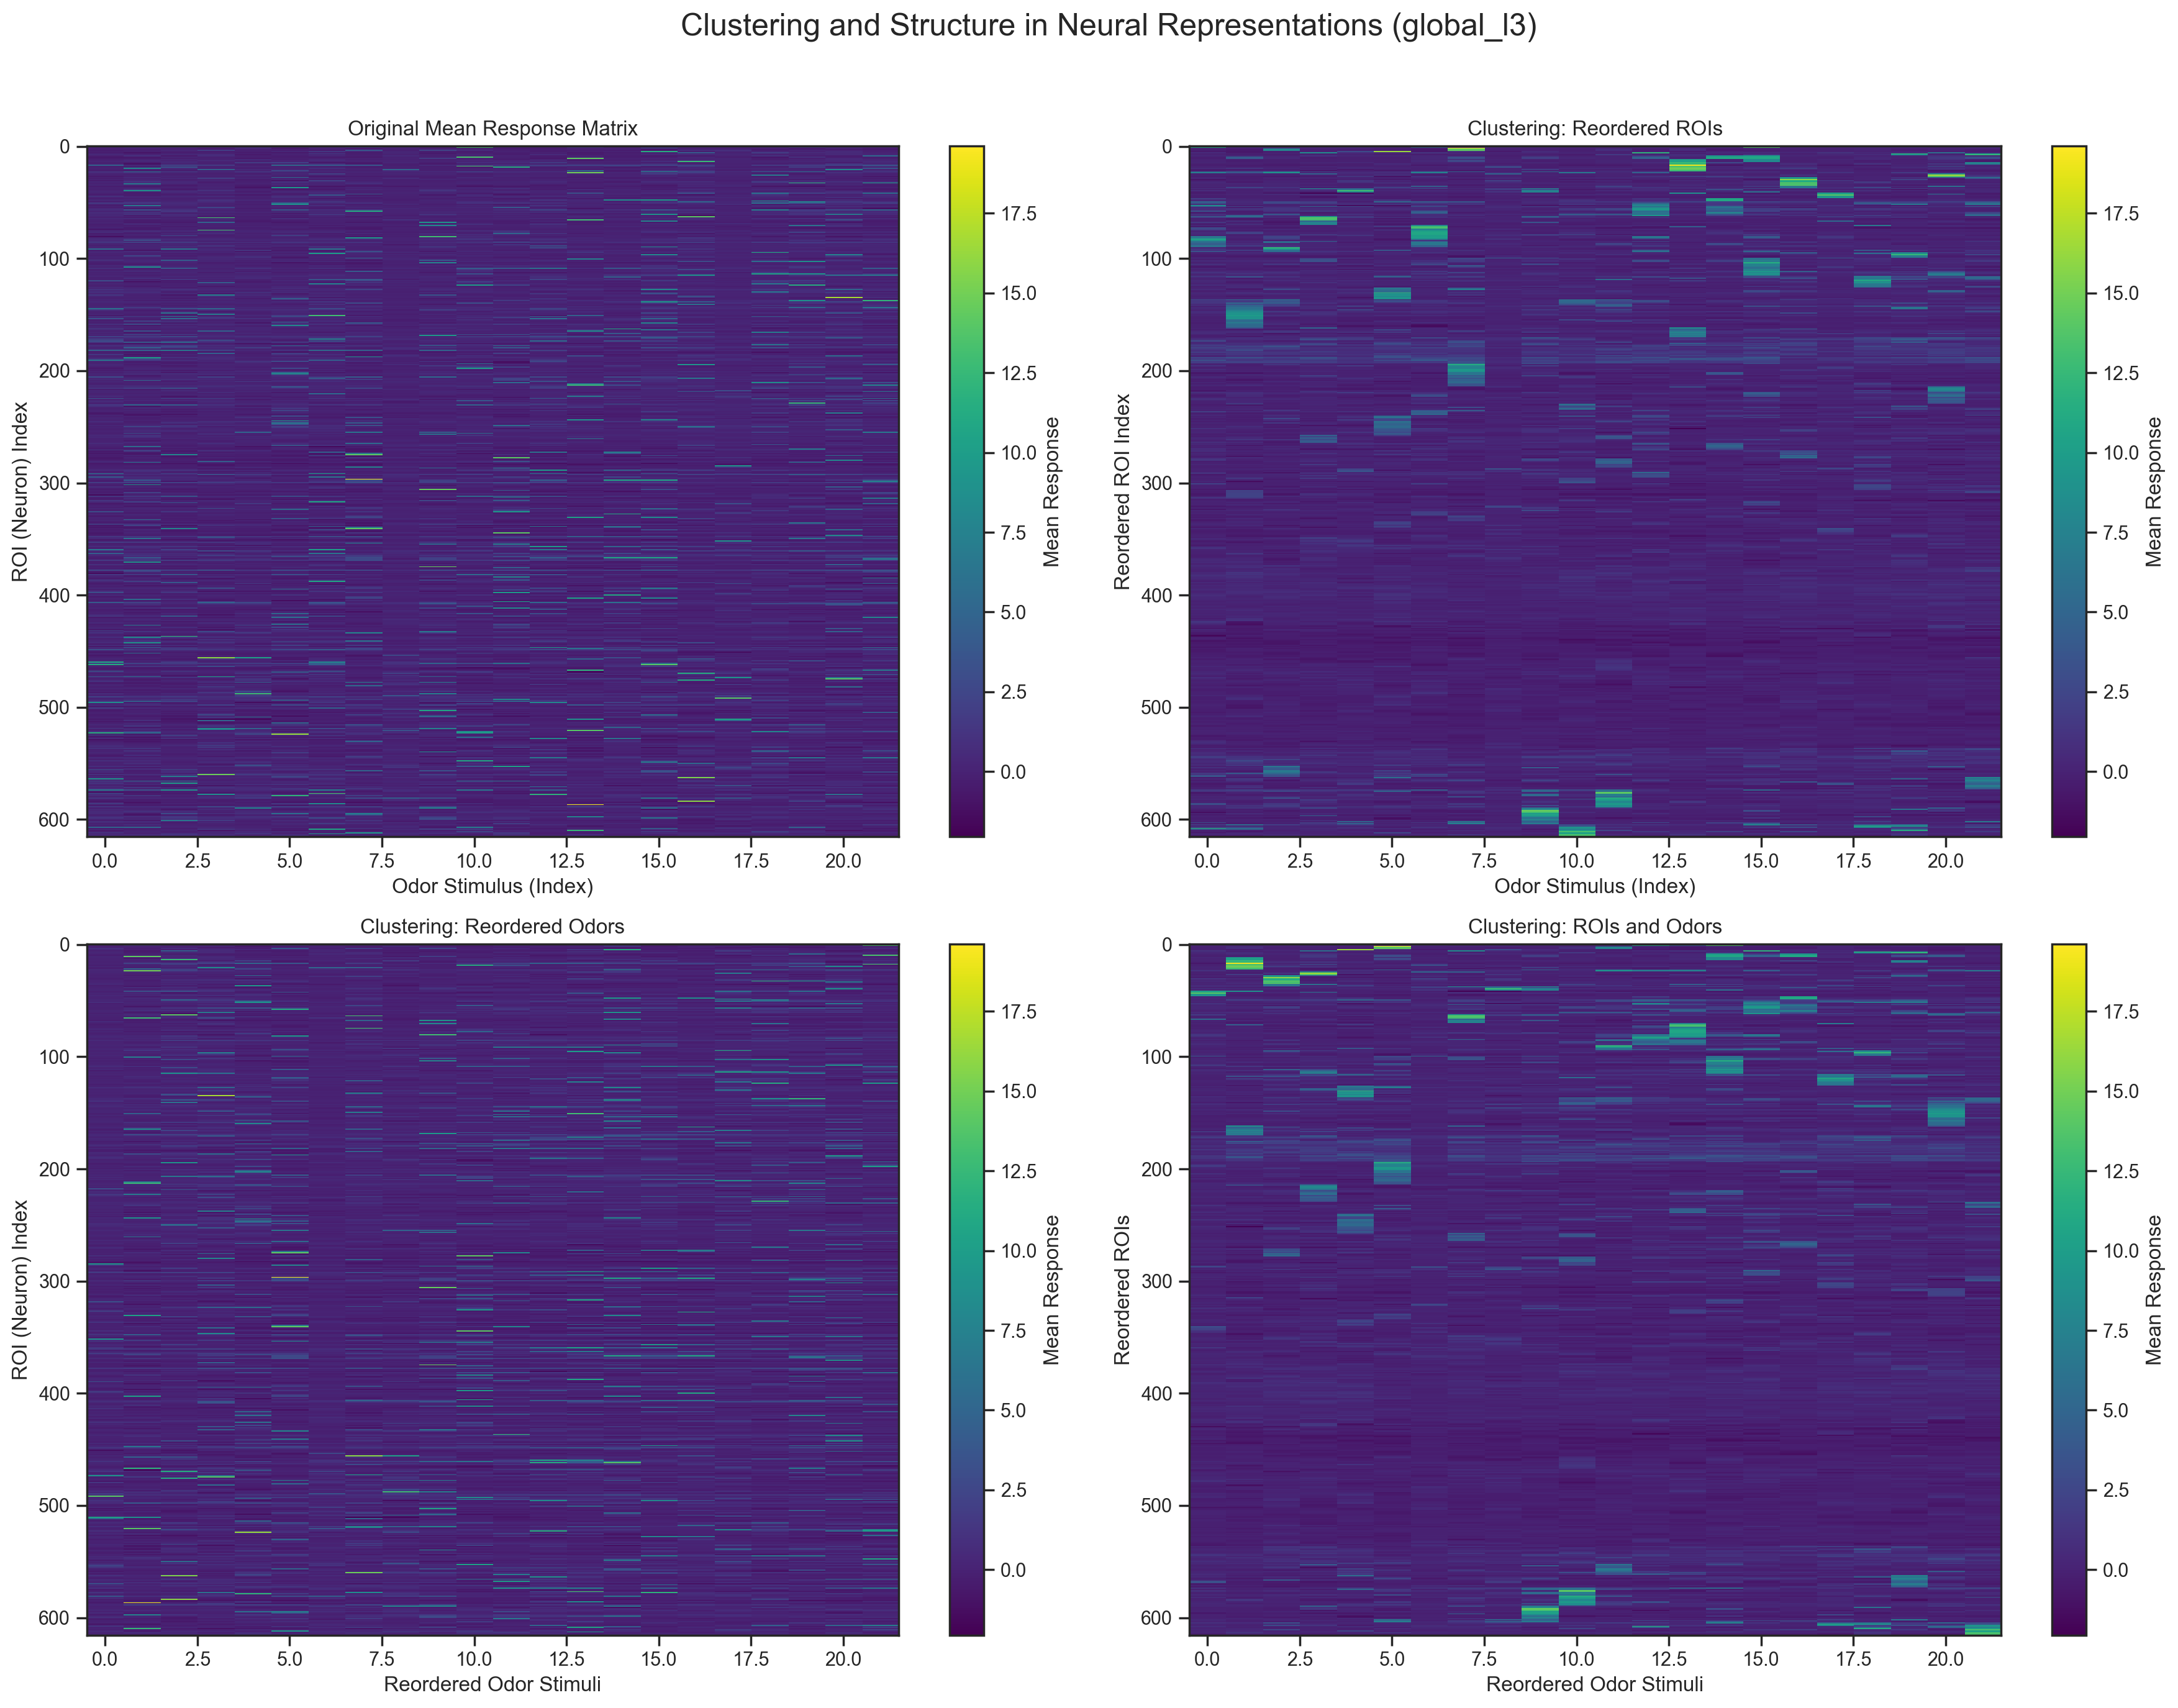

In [27]:
# Set the condition and access neural data
condition = "global_l3"
data = neural_dict[condition]  # shape: (trials, ROIs, odors)

# Step 1: Compute mean responses (ROIs x odors)
mean_responses = np.mean(data, axis=0)

# Step 2: Hierarchical clustering of ROIs
roi_distances = pdist(mean_responses, metric='euclidean')
roi_linkage = linkage(roi_distances, method='average')
roi_order = dendrogram(roi_linkage, no_plot=True)['leaves']

# Step 3: Hierarchical clustering of Odors
odor_distances = pdist(mean_responses.T, metric='correlation')
odor_linkage = linkage(odor_distances, method='average')
odor_order = dendrogram(odor_linkage, no_plot=True)['leaves']

# Step 4: Reorder matrices
mean_responses_rois = mean_responses[roi_order, :]
mean_responses_odors = mean_responses[:, odor_order]
mean_responses_both = mean_responses[roi_order, :][:, odor_order]

# Step 5: Plot all in one 2x2 figure
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle(f"Clustering and Structure in Neural Representations ({condition})", fontsize=18)

# Figure 1: Original Matrix
im1 = axes[0, 0].imshow(mean_responses, aspect='auto', cmap='viridis', interpolation='none')
axes[0, 0].set_title('Original Mean Response Matrix')
axes[0, 0].set_xlabel('Odor Stimulus (Index)')
axes[0, 0].set_ylabel('ROI (Neuron) Index')
fig.colorbar(im1, ax=axes[0, 0], label='Mean Response')

# Figure 2: Reordered by ROIs
im2 = axes[0, 1].imshow(mean_responses_rois, aspect='auto', cmap='viridis', interpolation='none')
axes[0, 1].set_title('Clustering: Reordered ROIs')
axes[0, 1].set_xlabel('Odor Stimulus (Index)')
axes[0, 1].set_ylabel('Reordered ROI Index')
fig.colorbar(im2, ax=axes[0, 1], label='Mean Response')

# Figure 3: Reordered by Odors
im3 = axes[1, 0].imshow(mean_responses_odors, aspect='auto', cmap='viridis', interpolation='none')
axes[1, 0].set_title('Clustering: Reordered Odors')
axes[1, 0].set_xlabel('Reordered Odor Stimuli')
axes[1, 0].set_ylabel('ROI (Neuron) Index')
fig.colorbar(im3, ax=axes[1, 0], label='Mean Response')

# Figure 4: Reordered by Both
im4 = axes[1, 1].imshow(mean_responses_both, aspect='auto', cmap='viridis', interpolation='none')
axes[1, 1].set_title('Clustering: ROIs and Odors')
axes[1, 1].set_xlabel('Reordered Odor Stimuli')
axes[1, 1].set_ylabel('Reordered ROIs')
fig.colorbar(im4, ax=axes[1, 1], label='Mean Response')


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [28]:
# ---- Sparseness analysis of the representations  ----
def compute_lifetime_sparseness(responses):
    """
    Returns: array of lifetime sparseness values per neuron
    """
    n = responses.shape[1]
    numerator = (np.sum(responses, axis=1) ** 2)
    denominator = np.sum(responses ** 2, axis=1) + 1e-10
    sparseness = 1 - (1/n) * (numerator / denominator)
    sparseness /= (1 - 1/n)
    return sparseness

def compute_population_sparseness(responses):
    """
    Returns: array of population sparseness values per odor
    """
    n = responses.shape[0]
    numerator = (np.sum(responses, axis=0) ** 2)
    denominator = np.sum(responses ** 2, axis=0) + 1e-10
    sparseness = 1 - (1/n) * (numerator / denominator)
    sparseness /= (1 - 1/n)
    return sparseness

# ---- SILHOUETTE SCORE ----

def compute_roi_clustering_silhouette(responses, n_clusters=6):
    """
    Returns: silhouette score of ROI clustering
    """
    model = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='average')
    labels = model.fit_predict(responses)
    score = silhouette_score(responses, labels, metric='euclidean')
    return score


lifetime_s = compute_lifetime_sparseness(mean_responses)
population_s = compute_population_sparseness(mean_responses)
silhouette = compute_roi_clustering_silhouette(mean_responses, n_clusters=6)

print("Mean lifetime sparseness:", np.mean(lifetime_s))
print("Mean population sparseness:", np.mean(population_s))
print("Silhouette score (ROI clustering):", silhouette)

Mean lifetime sparseness: 0.8238804647555116
Mean population sparseness: 0.9302638004811489
Silhouette score (ROI clustering): 0.43820521029555815


/Users/john/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


# Decoding Models

We evaluated decoding performance using three strategies: stratified five-fold cross-validation for balanced and efficient data use, leave-one-trial-out (LOTO) to test generalizability across trials, and a fixed 80/20 train-test split to simulate a standard classification pipeline.

In [29]:
# Cross-validated decoding model

results = []

for dataset_name, X_raw in neural_dict.items():
    if dataset_name.lower() == "model":
        continue

    print(f"\n--- Cross-validated decoding: {dataset_name} ---")

    try:
        # shape: (trials, ROIs, odors)
        n_trials, n_rois, n_odors = X_raw.shape

        # Reshape: (samples, features), where each sample = one trial of one odor
        X = X_raw.transpose(0, 2, 1).reshape(-1, n_rois)
        y = np.tile(np.arange(n_odors), n_trials)  # odor labels

        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Stratified 5-fold cross-validation
        min_trials_per_odor = n_trials
        n_splits = min(5, min_trials_per_odor)
        
        clf = LogisticRegression(max_iter=1000, multi_class='multinomial')
        cv = StratifiedKFold(n_splits, shuffle=True, random_state=42)
        scores = cross_val_score(clf, X_scaled, y, cv=cv)

        acc_mean = scores.mean()
        acc_std = scores.std()

        print(f"Cross-validated accuracy: {acc_mean:.2f} ± {acc_std:.2f}")
        results.append((dataset_name, acc_mean, acc_std))

    except Exception as e:
        print(f"Skipping {dataset_name}: {e}")
        results.append((dataset_name, None, None))

# --- summary ---
print("\n=== Cross-Validation Accuracy Summary ===")
for name, acc, std in results:
    if acc is not None:
        print(f"{name:15} → {acc:.2f} ± {std:.2f}")
    else:
        print(f"{name:15} → Skipped/Error")


--- Cross-validated decoding: Boutons ---
Cross-validated accuracy: 1.00 ± 0.00

--- Cross-validated decoding: TeLC L2 ---
Cross-validated accuracy: 1.00 ± 0.00

--- Cross-validated decoding: TeLC L3 ---
Cross-validated accuracy: 0.91 ± 0.09

--- Cross-validated decoding: clustered_l2 ---
Cross-validated accuracy: 1.00 ± 0.00

--- Cross-validated decoding: clustered_l3 ---
Cross-validated accuracy: 1.00 ± 0.00

--- Cross-validated decoding: global_l2 ---
Cross-validated accuracy: 1.00 ± 0.00

--- Cross-validated decoding: global_l3 ---
Cross-validated accuracy: 1.00 ± 0.00

--- Cross-validated decoding: tiled_l2 ---
Cross-validated accuracy: 0.99 ± 0.01

--- Cross-validated decoding: tiled_l3 ---
Cross-validated accuracy: 0.95 ± 0.06

=== Cross-Validation Accuracy Summary ===
Boutons         → 1.00 ± 0.00
TeLC L2         → 1.00 ± 0.00
TeLC L3         → 0.91 ± 0.09
clustered_l2    → 1.00 ± 0.00
clustered_l3    → 1.00 ± 0.00
global_l2       → 1.00 ± 0.00
global_l3       → 1.00 ± 0.00
ti

In [30]:
# Leave-One-Trial-Out decoding model

results = []

for dataset_name, X_raw in neural_dict.items():
    if dataset_name.lower() == "model":
        continue

    print(f"\n--- Leave-One-Trial-Out decoding: {dataset_name} ---")

    try:
        n_trials, n_rois, n_odors = X_raw.shape

        if n_trials < 2:
            raise ValueError("Need at least 2 trials per odor for leave-one-out")

        # Reshape to (odors, trials, ROIs)
        X_reorg = X_raw.transpose(2, 0, 1)

        accs = []

        for test_trial in range(n_trials):
            # Leave this trial out for all odors
            X_train = np.delete(X_reorg, test_trial, axis=1).reshape(-1, n_rois)
            y_train = np.repeat(np.arange(n_odors), n_trials - 1)

            X_test = X_reorg[:, test_trial, :]
            y_test = np.arange(n_odors)

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            clf = LogisticRegression(max_iter=1000, multi_class='multinomial')
            clf.fit(X_train_scaled, y_train)
            y_pred = clf.predict(X_test_scaled)

            accs.append(accuracy_score(y_test, y_pred))

        acc_mean = np.mean(accs)
        acc_std = np.std(accs)

        print(f"Leave-One-Trial-Out accuracy: {acc_mean:.2f} ± {acc_std:.2f}")
        results.append((dataset_name, acc_mean, acc_std))

    except Exception as e:
        print(f"Skipping {dataset_name}: {e}")
        results.append((dataset_name, None, None))

# --- summary ---
print("\n=== Leave-One-Trial-Out Accuracy Summary ===")
for name, acc, std in results:
    if acc is not None:
        print(f"{name:15} → {acc:.2f} ± {std:.2f}")
    else:
        print(f"{name:15} → Skipped/Error")


--- Leave-One-Trial-Out decoding: Boutons ---
Leave-One-Trial-Out accuracy: 1.00 ± 0.00

--- Leave-One-Trial-Out decoding: TeLC L2 ---
Leave-One-Trial-Out accuracy: 1.00 ± 0.00

--- Leave-One-Trial-Out decoding: TeLC L3 ---
Leave-One-Trial-Out accuracy: 0.97 ± 0.04

--- Leave-One-Trial-Out decoding: clustered_l2 ---
Leave-One-Trial-Out accuracy: 1.00 ± 0.00

--- Leave-One-Trial-Out decoding: clustered_l3 ---
Leave-One-Trial-Out accuracy: 1.00 ± 0.00

--- Leave-One-Trial-Out decoding: global_l2 ---
Leave-One-Trial-Out accuracy: 1.00 ± 0.00

--- Leave-One-Trial-Out decoding: global_l3 ---
Leave-One-Trial-Out accuracy: 1.00 ± 0.00

--- Leave-One-Trial-Out decoding: tiled_l2 ---
Leave-One-Trial-Out accuracy: 0.99 ± 0.02

--- Leave-One-Trial-Out decoding: tiled_l3 ---
Leave-One-Trial-Out accuracy: 0.97 ± 0.02

=== Leave-One-Trial-Out Accuracy Summary ===
Boutons         → 1.00 ± 0.00
TeLC L2         → 1.00 ± 0.00
TeLC L3         → 0.97 ± 0.04
clustered_l2    → 1.00 ± 0.00
clustered_l3    →

In [ ]:
# split datasets

results = []

for dataset_name, X_raw in neural_dict.items():
    if dataset_name.lower() == "model":
        continue

    print(f"\n--- Split dataset: {dataset_name} ---")

    try:
        n_trials, n_rois, n_odors = X_raw.shape

        # 80/20 split per odor
        n_test = math.ceil(n_trials * 0.2)
        n_train = n_trials - n_test

        if n_train + n_test > n_trials:
            raise ValueError(f"Too few trials for split: {n_trials}")

        # reshape: (odors, trials, ROIs)
        X_reorg = X_raw.transpose(2, 0, 1)

        rng = np.random.default_rng(seed=42)
        trial_order = np.array([rng.permutation(n_trials) for _ in range(n_odors)])
        train_idx = trial_order[:, :n_train]
        test_idx = trial_order[:, n_train:n_train + n_test]

        # build datasets
        X_train = np.stack([X_reorg[o, train_idx[o], :] for o in range(n_odors)]).reshape(-1, n_rois)
        y_train = np.repeat(np.arange(n_odors), n_train)

        X_test = np.stack([X_reorg[o, test_idx[o], :] for o in range(n_odors)]).reshape(-1, n_rois)
        y_test = np.repeat(np.arange(n_odors), n_test)

        # classification
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        clf = LogisticRegression(max_iter=1000, multi_class='multinomial')
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)

        acc = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {acc:.2f}")
        results.append((dataset_name, acc))

    except Exception as e:
        print(f"Skipping {dataset_name}: {e}")
        results.append((dataset_name, None))


print("\n=== Decoding Accuracy Summary ===")
for name, acc in results:
    status = f"{acc:.2f}" if acc is not None else "Skipped/Error"
    print(f"{name:15} → {status}")


--- Split dataset: Boutons ---
Accuracy: 1.00

--- Split dataset: TeLC L2 ---
Accuracy: 0.91

--- Split dataset: TeLC L3 ---
Accuracy: 0.82

--- Split dataset: clustered_l2 ---
Accuracy: 1.00

--- Split dataset: clustered_l3 ---
Accuracy: 1.00

--- Split dataset: global_l2 ---
Accuracy: 0.98

--- Split dataset: global_l3 ---
Accuracy: 1.00

--- Split dataset: tiled_l2 ---
Accuracy: 0.98

--- Split dataset: tiled_l3 ---
Accuracy: 0.91

=== Decoding Accuracy Summary ===
Boutons         → 1.00
TeLC L2         → 0.91
TeLC L3         → 0.82
clustered_l2    → 1.00
clustered_l3    → 1.00
global_l2       → 0.98
global_l3       → 1.00
tiled_l2        → 0.98
tiled_l3        → 0.91


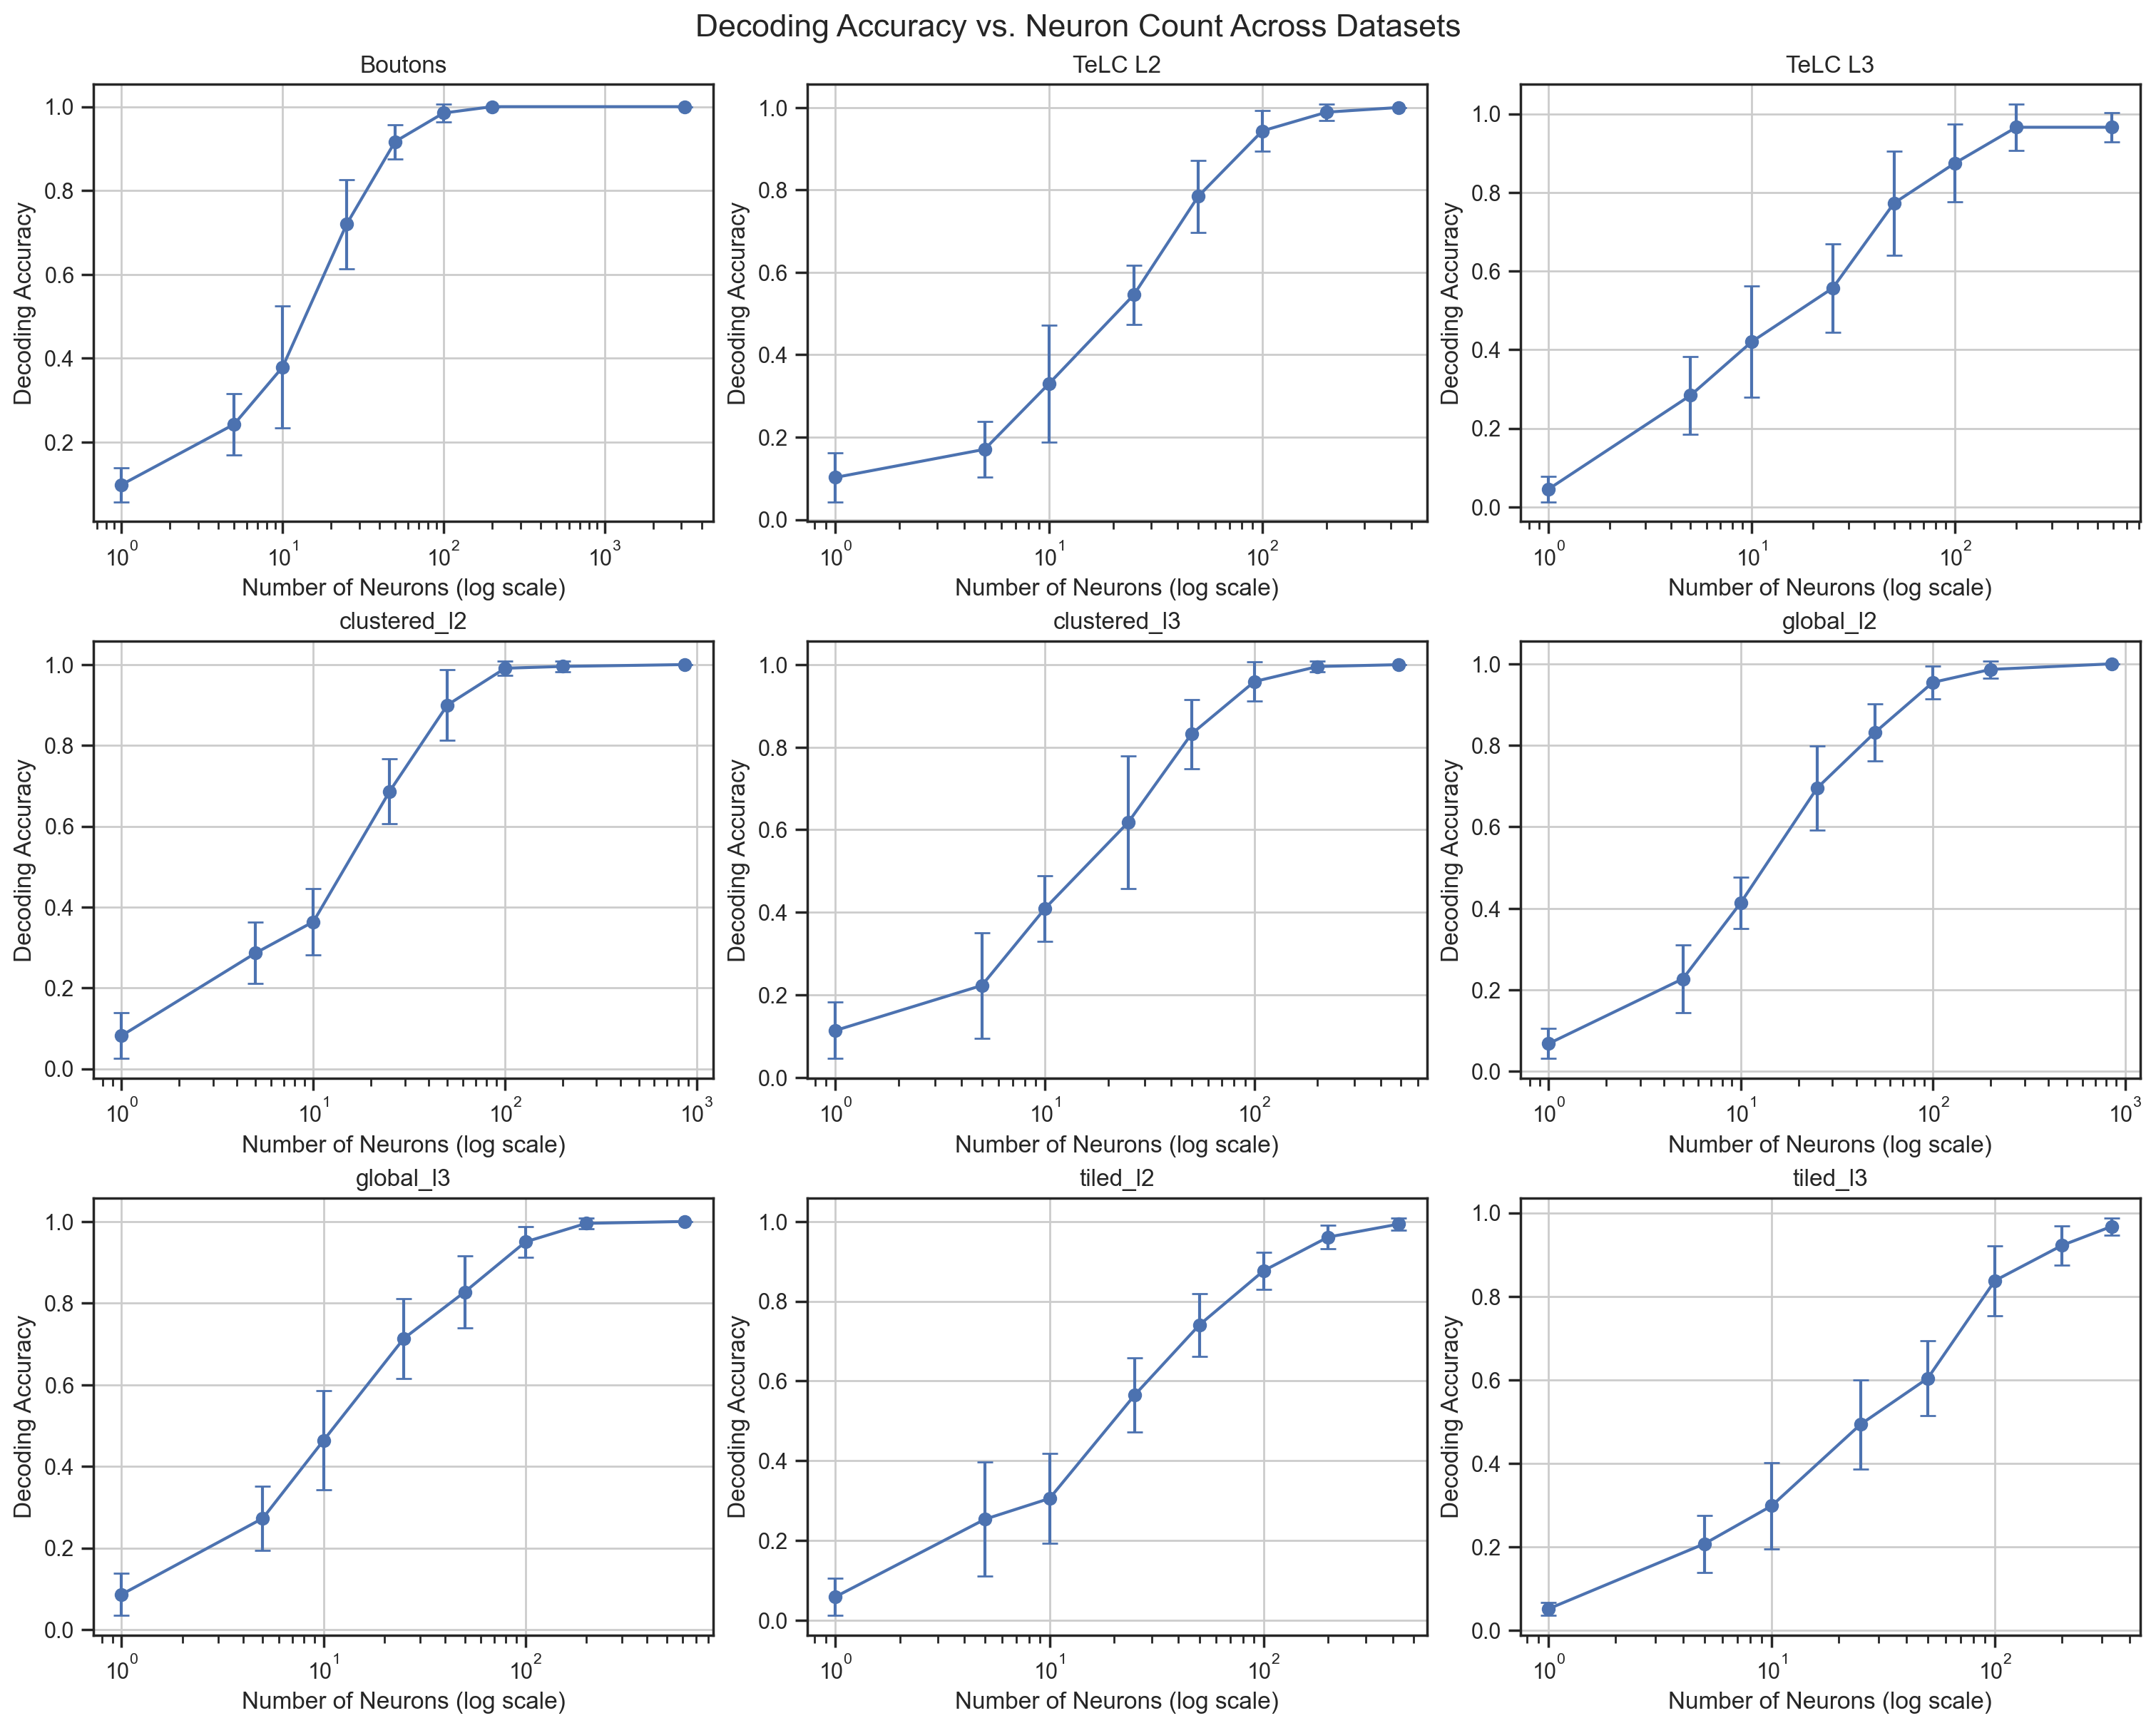

In [ ]:
# decoding performance by varying number of neurons

group_results = {}

for dataset_name, X_raw in neural_dict.items():
    if dataset_name.lower() == "model":
        continue

    try:
        n_trials, n_rois, n_odors = X_raw.shape
        default_neuron_counts = [1, 5, 10, 25, 50, 100, 200, n_rois]
        if n_trials < 2:
            raise ValueError("Need at least 2 trials per odor for leave-one-out")

        neuron_counts = [n for n in default_neuron_counts if n <= n_rois]
        if n_rois not in neuron_counts:
            neuron_counts.append(n_rois)

        X_reorg = X_raw.transpose(2, 0, 1)  # (odors, trials, ROIs)

        acc_means = []
        acc_stds = []

        for n in neuron_counts:
            accs = []
            for test_trial in range(n_trials):
                roi_idx = np.random.choice(n_rois, n, replace=False)

                X_train = np.delete(X_reorg[:, :, roi_idx], test_trial, axis=1).reshape(-1, n)
                y_train = np.repeat(np.arange(n_odors), n_trials - 1)

                X_test = X_reorg[:, test_trial, roi_idx]
                y_test = np.arange(n_odors)

                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)

                clf = LogisticRegression(max_iter=1000, multi_class='multinomial')
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)

                accs.append(accuracy_score(y_test, y_pred))

            acc_means.append(np.mean(accs))
            acc_stds.append(np.std(accs))

        group_results[dataset_name] = {
            "neuron_counts": neuron_counts,
            "acc_means": acc_means,
            "acc_stds": acc_stds
        }

    except Exception as e:
        print(f"Skipping {dataset_name}: {e}")

# ------------------ Plotting ------------------
fig, axes = plt.subplots(3, 3, figsize=(15, 12), constrained_layout=True)
axes = axes.flatten()

for i, (group, res) in enumerate(group_results.items()):
    ax = axes[i]
    ax.errorbar(res["neuron_counts"], res["acc_means"], yerr=res["acc_stds"],
                marker='o', capsize=4)
    ax.set_xscale('log')
    ax.set_xlabel('Number of Neurons (log scale)')
    ax.set_ylabel('Decoding Accuracy')
    ax.set_title(f'{group}')
    ax.grid(True)

for j in range(len(group_results), 9):
    fig.delaxes(axes[j])

fig.suptitle('Decoding Accuracy vs. Neuron Count Across Datasets', fontsize=16)
plt.show()


# Neuron Exclusion Decoding Analysis

This section evaluates how decoding performance changes as high-response or high-sparseness neurons are systematically excluded, revealing how odor information is distributed across the neural population.

running Boutons
running TeLC L2
running TeLC L3
running clustered_l2
running clustered_l3
running global_l2
running global_l3
running tiled_l2
running tiled_l3


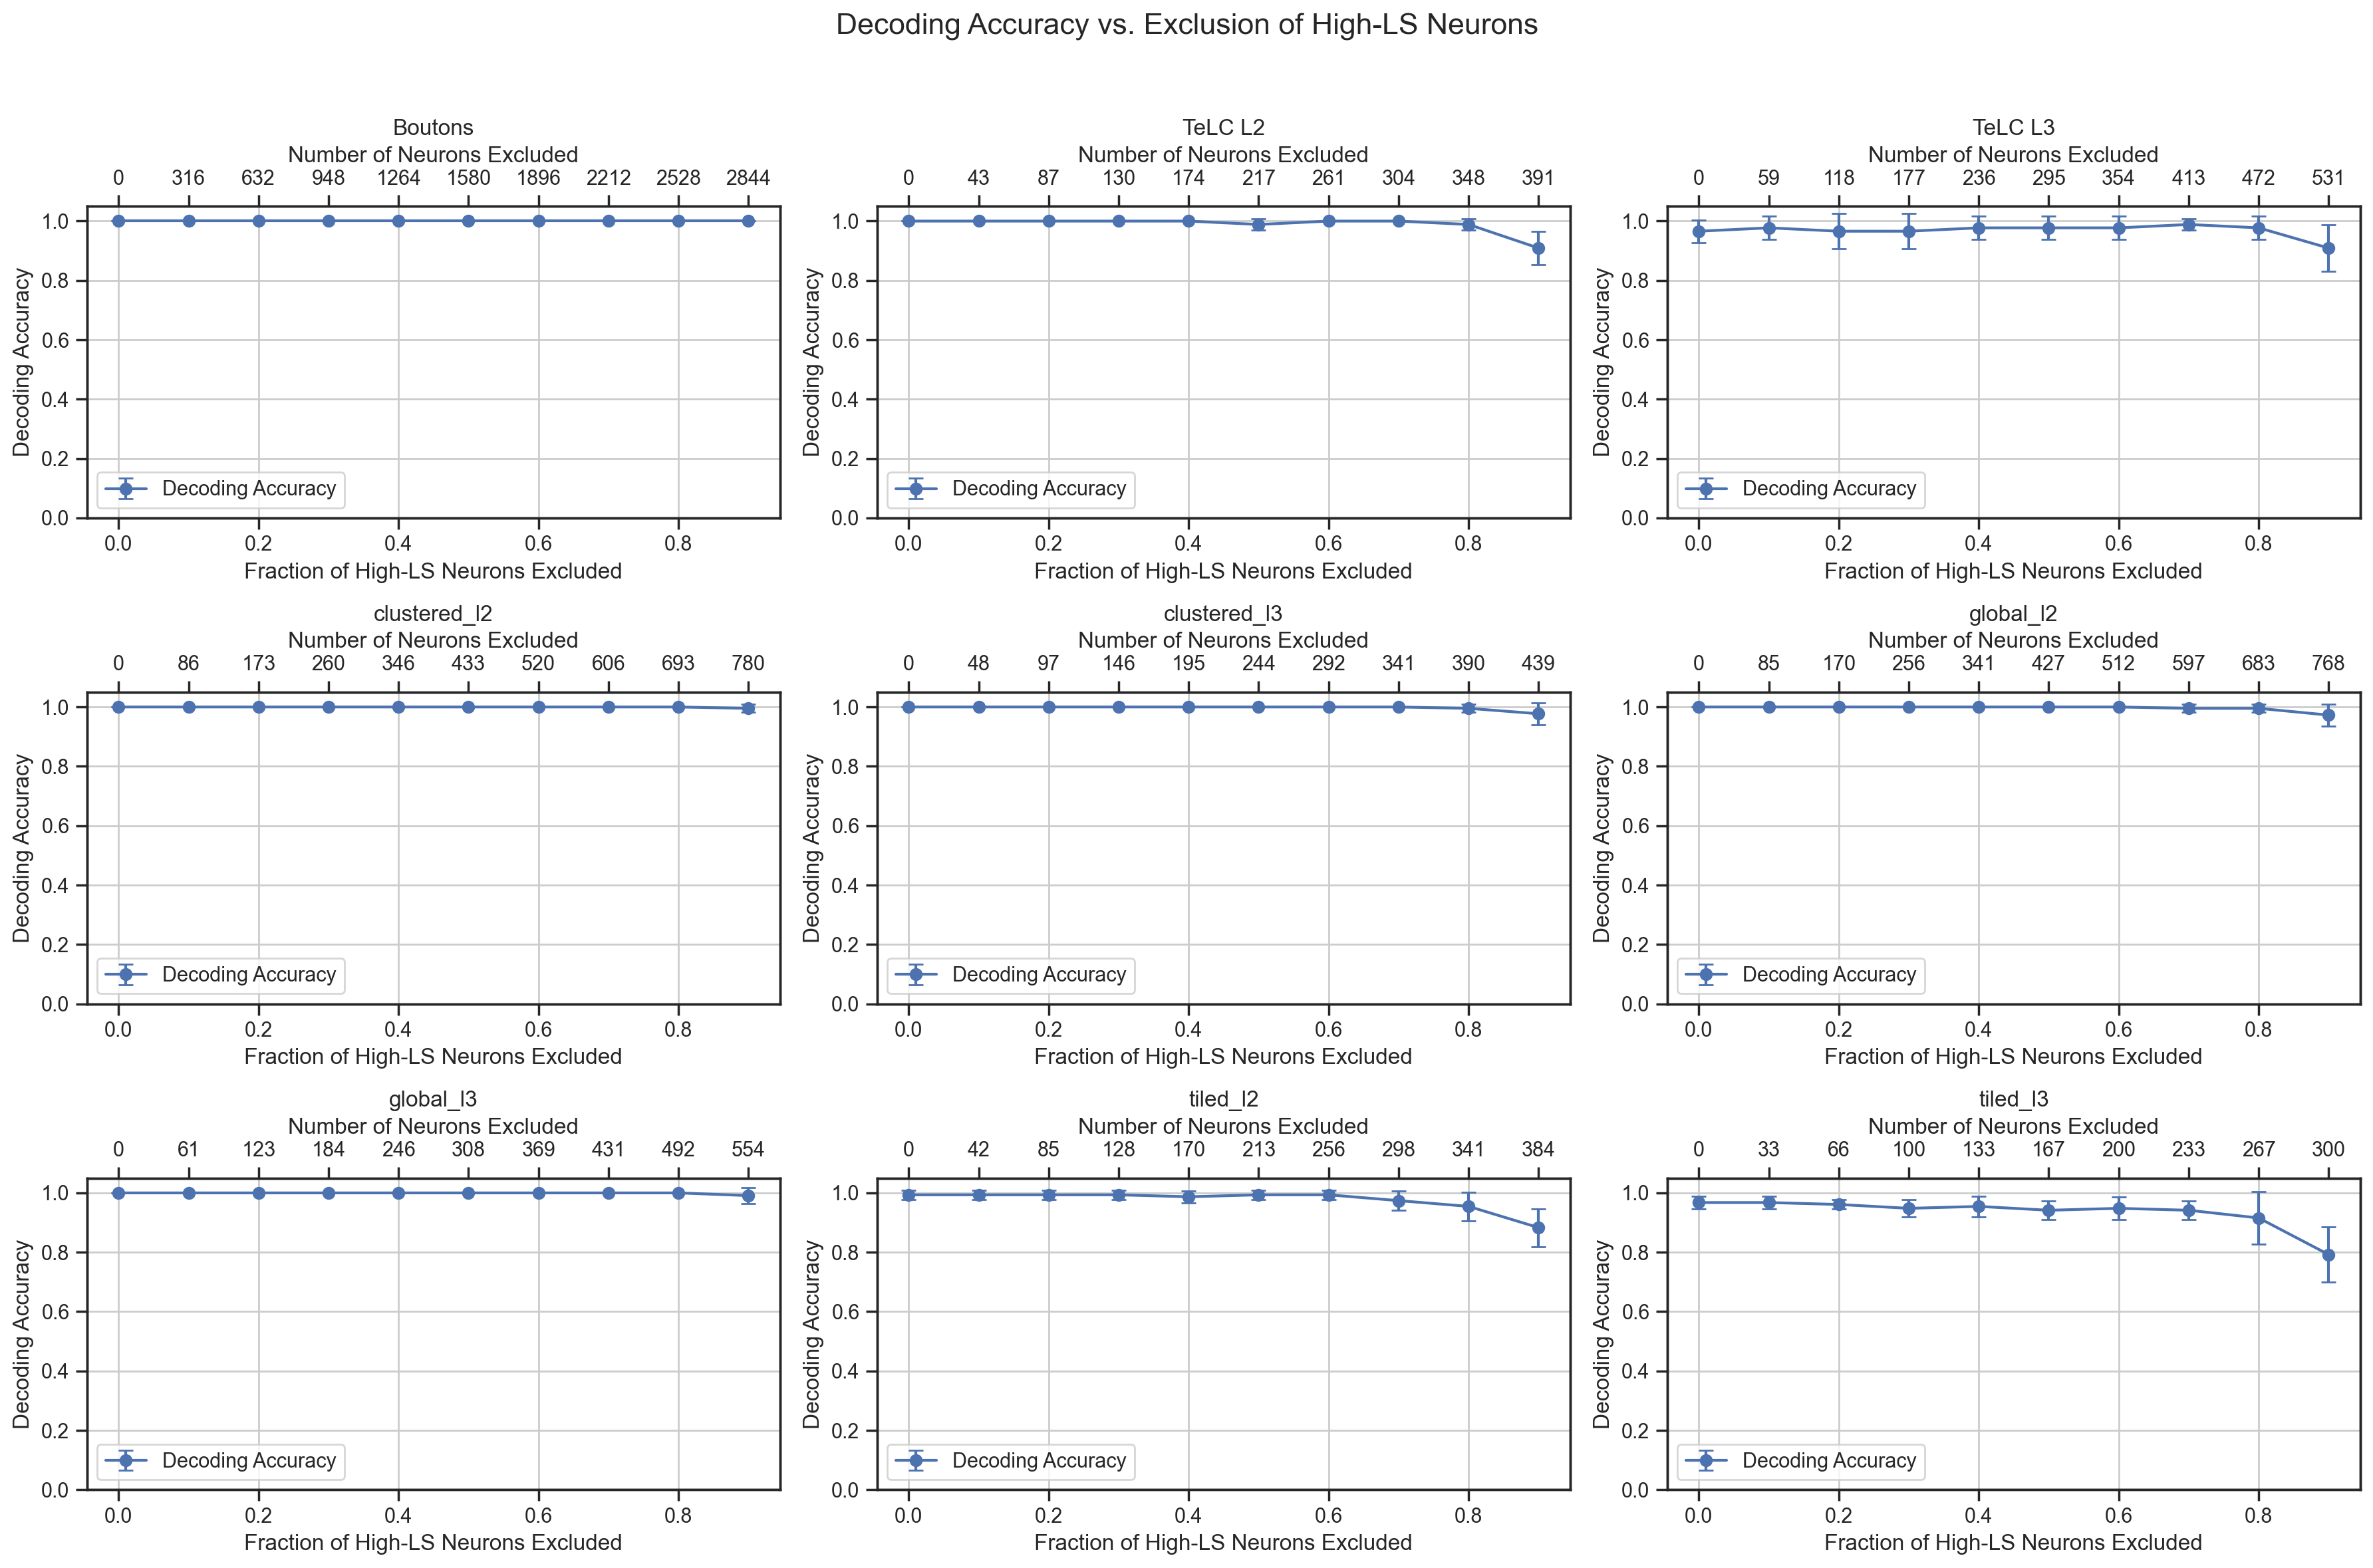

In [32]:
def lifetime_sparseness(resp):  # resp shape: (n_trials, n_odors)
    mean_resp = np.mean(resp, axis=0)
    num = 1 - (np.square(mean_resp).sum() / (np.square(np.abs(mean_resp)).sum() + 1e-10))
    denom = 1 - (1 / len(mean_resp))
    return num / denom if denom != 0 else 0

group_exclusion_results = {}

for dataset_name, X_raw in neural_dict.items():
    if dataset_name.lower() == "model":
        continue

    try:
        print(f"running {dataset_name}")
        n_trials, n_rois, n_odors = X_raw.shape
        if n_trials < 2:
            continue

        # Compute LS for each ROI
        ls_scores = []
        for roi in range(n_rois):
            resp = X_raw[:, roi, :]  # shape: (n_trials, n_odors)
            ls = lifetime_sparseness(resp)
            ls_scores.append(ls)
        ls_scores = np.array(ls_scores)
        sorted_rois = np.argsort(ls_scores)[::-1]  # High to low LS

        # Fractions to test
        fractions = np.linspace(0.0, 0.9, 10)
        acc_means, acc_stds, n_excluded = [], [], []

        for frac in fractions:
            n_exclude = int(frac * n_rois)
            n_excluded.append(n_exclude)

            rois_to_use = sorted_rois[n_exclude:]
            if len(rois_to_use) < 2:
                acc_means.append(np.nan)
                acc_stds.append(np.nan)
                continue

            # Reorg for decoding: (odors, trials, selected ROIs)
            X_reorg = X_raw[:, rois_to_use, :].transpose(2, 0, 1)

            accs = []

            for test_trial in range(n_trials):
                X_train = np.delete(X_reorg, test_trial, axis=1).reshape(-1, len(rois_to_use))
                y_train = np.repeat(np.arange(n_odors), n_trials - 1)

                X_test = X_reorg[:, test_trial, :]
                y_test = np.arange(n_odors)

                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)

                clf = LogisticRegression(max_iter=1000, multi_class='multinomial')
                clf.fit(X_train_scaled, y_train)
                y_pred = clf.predict(X_test_scaled)

                accs.append(accuracy_score(y_test, y_pred))

            acc_means.append(np.mean(accs))
            acc_stds.append(np.std(accs))

        group_exclusion_results[dataset_name] = {
            "fraction_excluded": fractions,
            "n_excluded": n_excluded,
            "acc_mean": acc_means,
            "acc_std": acc_stds
        }

    except Exception as e:
        print(f"Skipping {dataset_name}: {e}")

# ------------------ Plotting ------------------

n_groups = len(group_exclusion_results)
n_cols = 3
n_rows = int(np.ceil(n_groups / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), squeeze=False)
axes = axes.flatten()

for idx, (group, res) in enumerate(group_exclusion_results.items()):
    ax = axes[idx]
    ax.errorbar(res["fraction_excluded"], res["acc_mean"], yerr=res["acc_std"],
                marker='o', capsize=4, label='Decoding Accuracy')
    ax.set_ylim(0, 1.05)
    ax.set_xlabel('Fraction of High-LS Neurons Excluded')
    ax.set_ylabel('Decoding Accuracy')
    ax.set_title(f'{group}')
    ax.grid(True)
    ax.legend()

    # actual neuron count
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(res["fraction_excluded"])
    ax2.set_xticklabels([str(n) for n in res["n_excluded"]])
    ax2.set_xlabel("Number of Neurons Excluded")

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Decoding Accuracy vs. Exclusion of High-LS Neurons', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


running Boutons
running TeLC L2
running TeLC L3
running clustered_l2
running clustered_l3
running global_l2
running global_l3
running tiled_l2
running tiled_l3


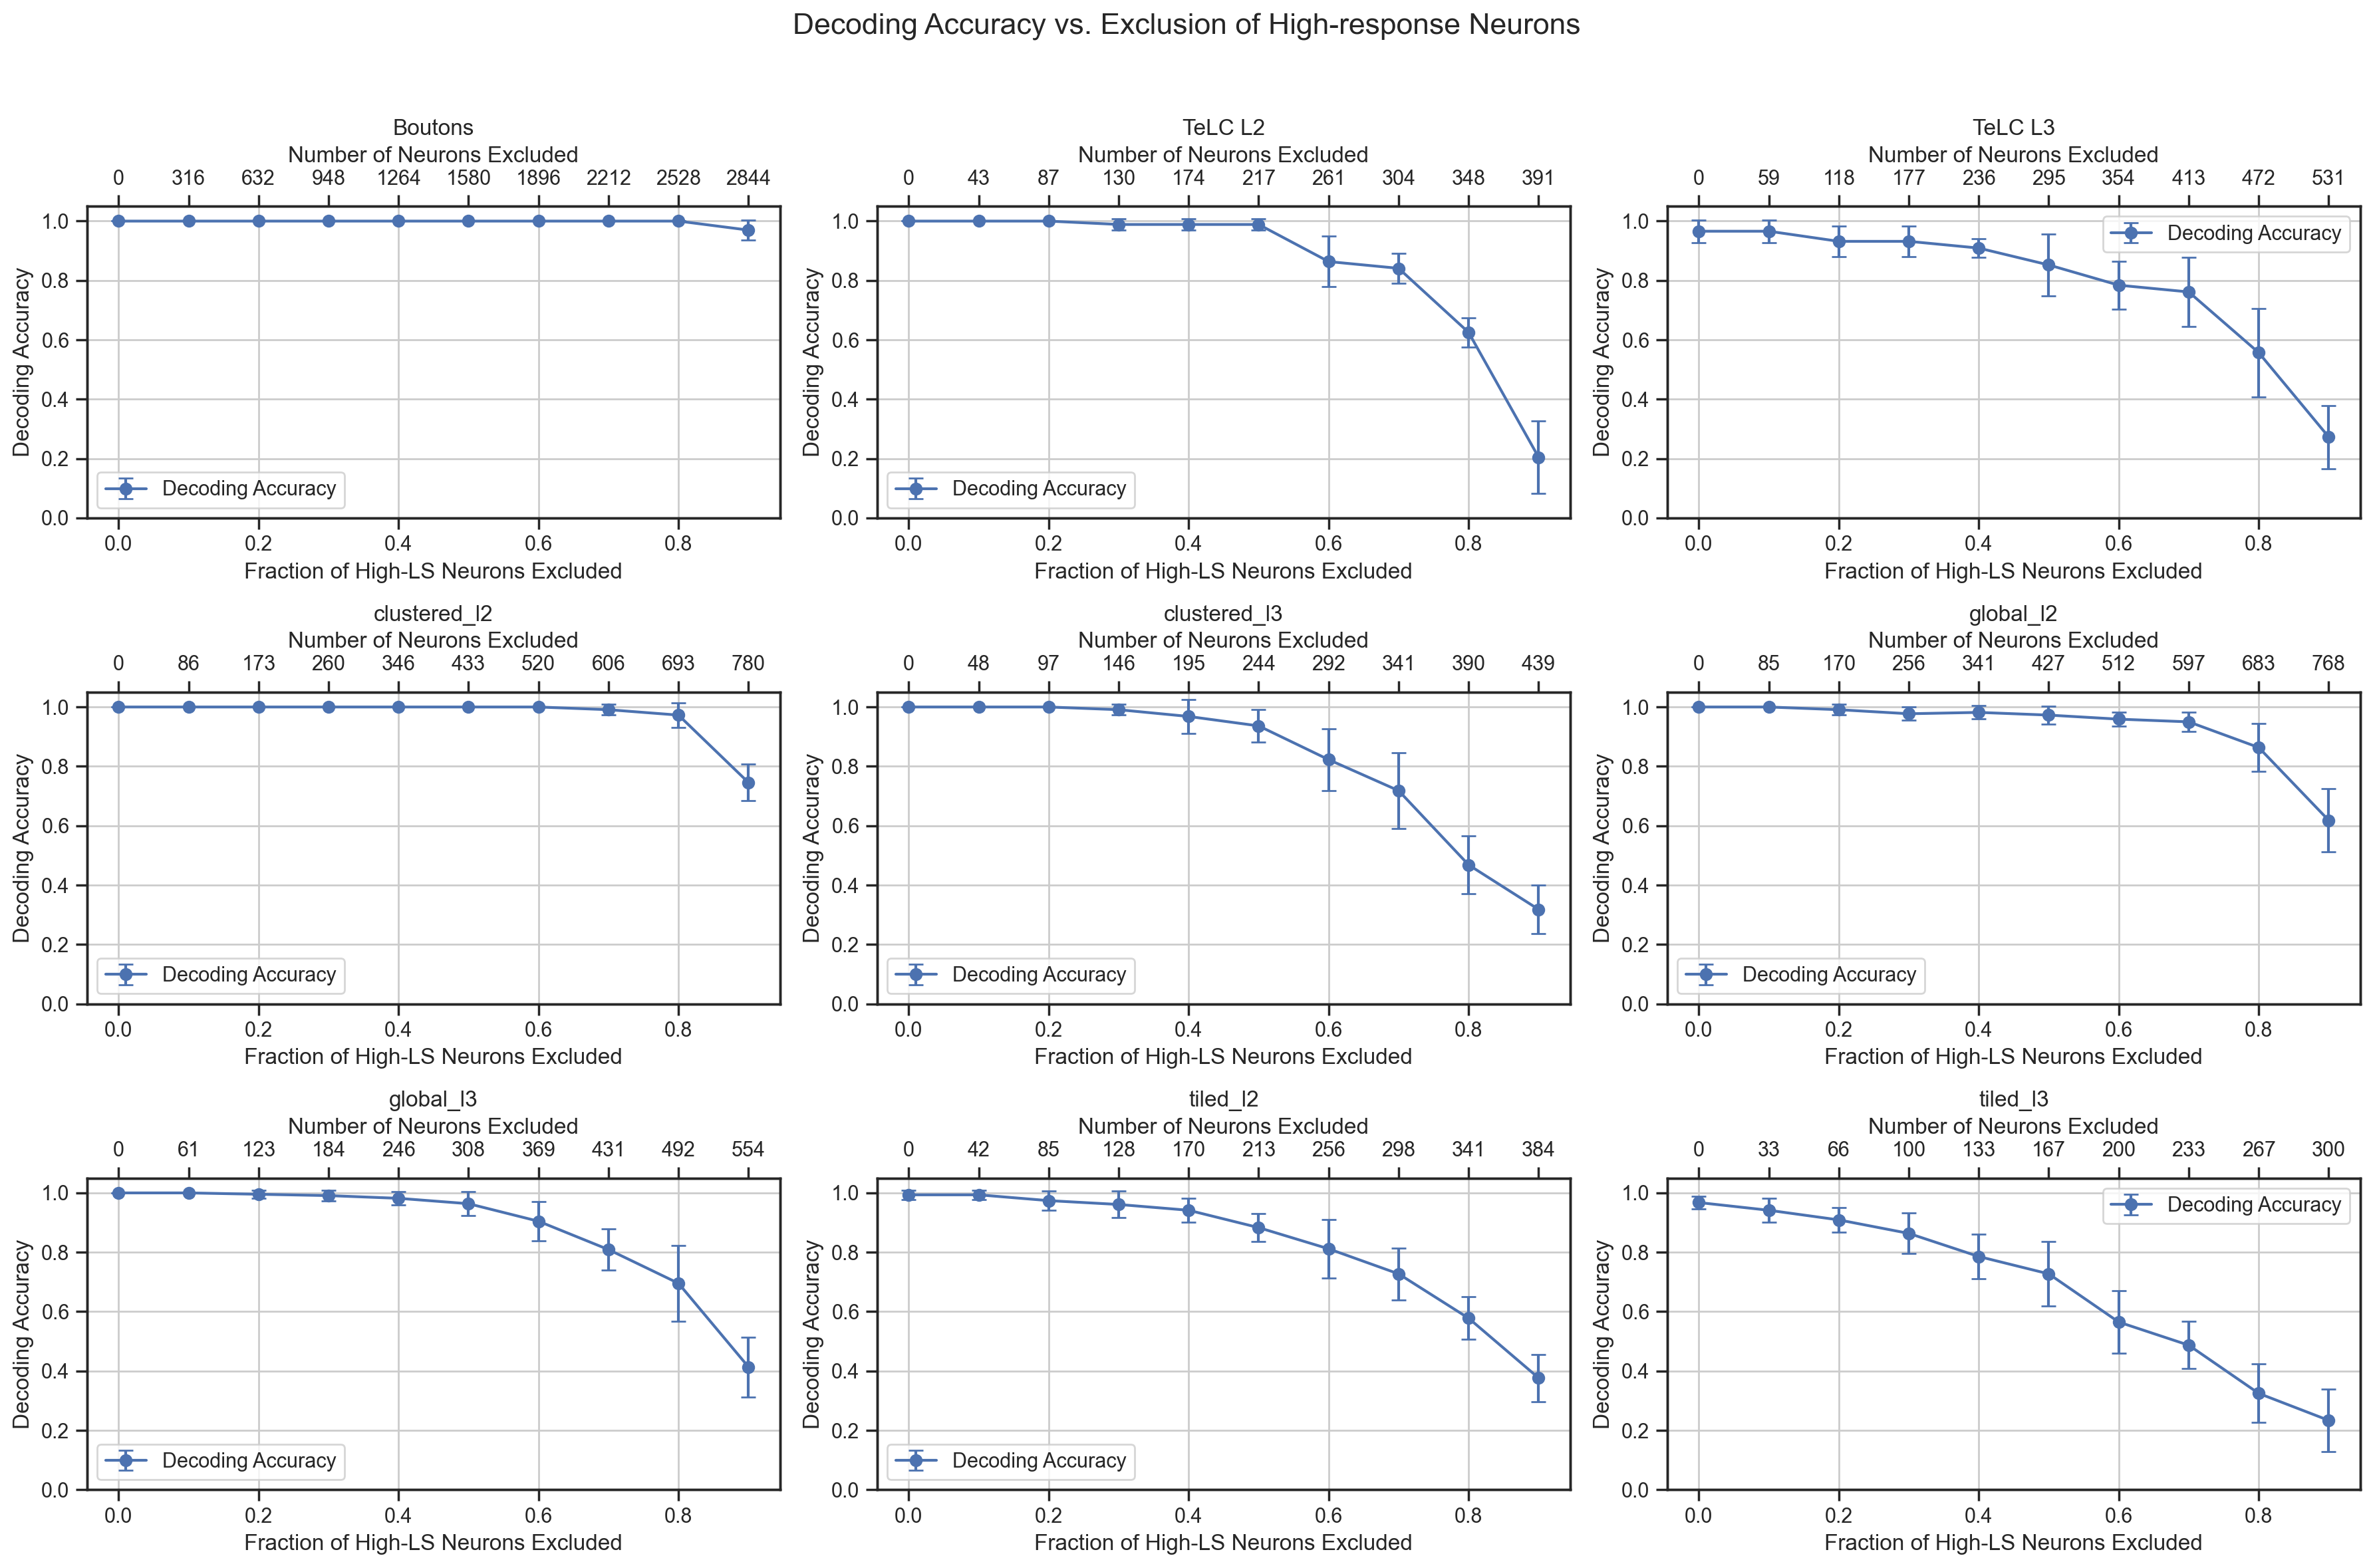

In [33]:
group_exclusion_results = {}

for dataset_name, X_raw in neural_dict.items():
    if dataset_name.lower() == "model":
        continue

    try:
        print(f"running {dataset_name}")
        n_trials, n_rois, n_odors = X_raw.shape
        if n_trials < 2:
            continue

        # Compute mean response across all trials and odors
        mean_response_strength = np.mean(np.abs(X_raw), axis=(0, 2))  # shape: (n_rois,)
        sorted_rois = np.argsort(mean_response_strength)[::-1]  # High to low response


        # Fractions to test
        fractions = np.linspace(0.0, 0.9, 10)
        acc_means, acc_stds, n_excluded = [], [], []

        for frac in fractions:
            n_exclude = int(frac * n_rois)
            n_excluded.append(n_exclude)

            rois_to_use = sorted_rois[n_exclude:]
            if len(rois_to_use) < 2:
                acc_means.append(np.nan)
                acc_stds.append(np.nan)
                continue

            # Reorg for decoding: (odors, trials, selected ROIs)
            X_reorg = X_raw[:, rois_to_use, :].transpose(2, 0, 1)

            accs = []

            for test_trial in range(n_trials):
                X_train = np.delete(X_reorg, test_trial, axis=1).reshape(-1, len(rois_to_use))
                y_train = np.repeat(np.arange(n_odors), n_trials - 1)

                X_test = X_reorg[:, test_trial, :]
                y_test = np.arange(n_odors)

                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)

                clf = LogisticRegression(max_iter=1000, multi_class='multinomial')
                clf.fit(X_train_scaled, y_train)
                y_pred = clf.predict(X_test_scaled)

                accs.append(accuracy_score(y_test, y_pred))

            acc_means.append(np.mean(accs))
            acc_stds.append(np.std(accs))

        group_exclusion_results[dataset_name] = {
            "fraction_excluded": fractions,
            "n_excluded": n_excluded,
            "acc_mean": acc_means,
            "acc_std": acc_stds
        }

    except Exception as e:
        print(f"Skipping {dataset_name}: {e}")

# ------------------ Plotting ------------------

n_groups = len(group_exclusion_results)
n_cols = 3
n_rows = int(np.ceil(n_groups / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), squeeze=False)
axes = axes.flatten()

for idx, (group, res) in enumerate(group_exclusion_results.items()):
    ax = axes[idx]
    ax.errorbar(res["fraction_excluded"], res["acc_mean"], yerr=res["acc_std"],
                marker='o', capsize=4, label='Decoding Accuracy')
    ax.set_ylim(0, 1.05)
    ax.set_xlabel('Fraction of High-LS Neurons Excluded')
    ax.set_ylabel('Decoding Accuracy')
    ax.set_title(f'{group}')
    ax.grid(True)
    ax.legend()

    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(res["fraction_excluded"])
    ax2.set_xticklabels([str(n) for n in res["n_excluded"]])
    ax2.set_xlabel("Number of Neurons Excluded")

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Decoding Accuracy vs. Exclusion of High-response Neurons', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# RDM, PCA, RSA

This section analyzes the geometry of odor representations using representational dissimilarity matrices (RDMs), principal component analysis (PCA), and representational similarity analysis (RSA) to assess how neural activity reflects odor identity and chemical structure.

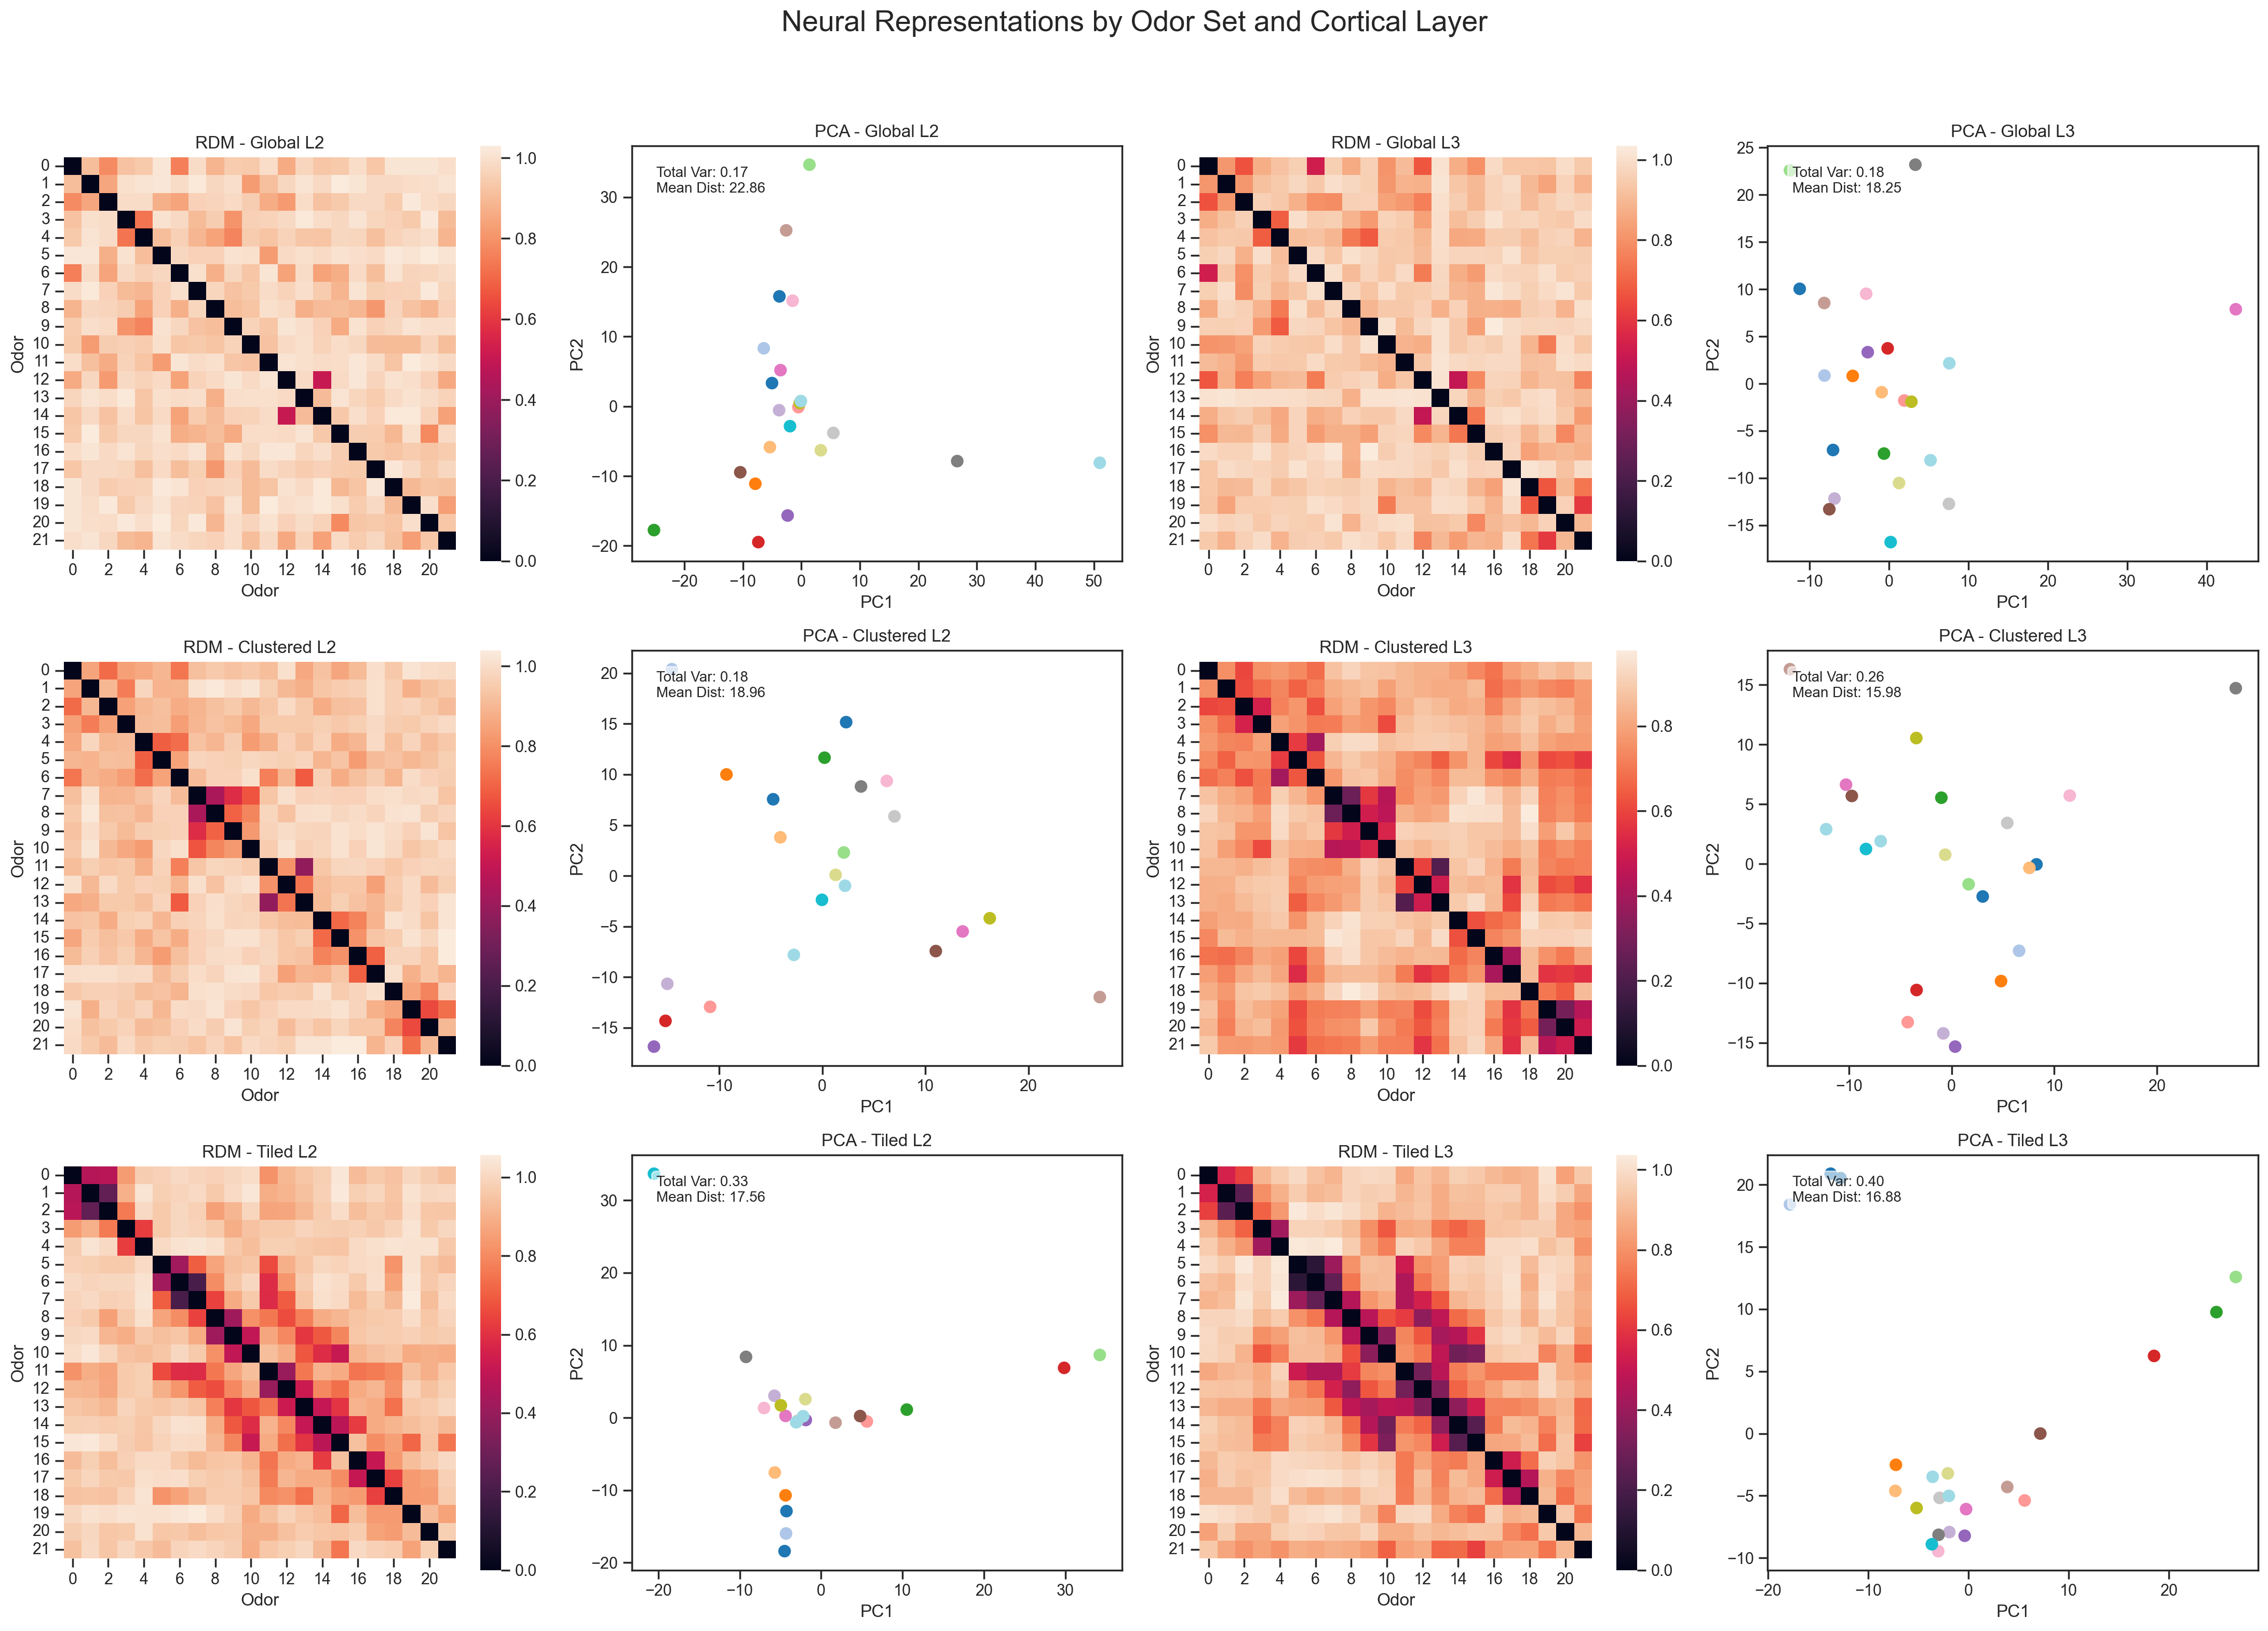

In [34]:
conditions = [
    ('global_l2', 'Global L2'),
    ('global_l3', 'Global L3'),
    ('clustered_l2', 'Clustered L2'),
    ('clustered_l3', 'Clustered L3'),
    ('tiled_l2', 'Tiled L2'),
    ('tiled_l3', 'Tiled L3')
]

fig, axes = plt.subplots(3, 4, figsize=(22, 16))
fig.suptitle("Neural Representations by Odor Set and Cortical Layer", fontsize=20)


for i, (key, title) in enumerate(conditions):
    # Get neural data and compute mean odor response
    data = neural_dict[key]  # (trials, neurons, odors)
    mean_response = data.mean(axis=0).T  # (odors, neurons)

    # Compute RDM (correlation distance)
    rdm = squareform(pdist(mean_response, metric='correlation'))

    ax_rdm = axes[i // 2, (i % 2) * 2]
    sns.heatmap(rdm, ax=ax_rdm, square=True, cbar=True)
    ax_rdm.set_title(f"RDM - {title}", fontsize=12)
    ax_rdm.set_xlabel("Odor")
    ax_rdm.set_ylabel("Odor")

    # PCA for visualization
    pca = PCA(n_components=2)
    proj = pca.fit_transform(mean_response)

    total_variance = pca.explained_variance_ratio_.sum()
    mean_distance = np.mean(pdist(proj, metric='euclidean'))

    ax_pca = axes[i // 2, (i % 2) * 2 + 1]
    scatter = ax_pca.scatter(proj[:, 0], proj[:, 1], c=np.arange(22), cmap='tab20', s=60)
    ax_pca.set_title(f"PCA - {title}", fontsize=12)
    ax_pca.set_xlabel("PC1")
    ax_pca.set_ylabel("PC2")

    # Annotate the PCA plot
    ax_pca.text(0.05, 0.95,
                f"Total Var: {total_variance:.2f}\nMean Dist: {mean_distance:.2f}",
                transform=ax_pca.transAxes,
                fontsize=10,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()